In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Učitaj podatke za opterećenje

In [2]:
import re

# Ucitaj podatke

# Provjeri nazive sheetova
all_sheets = pd.ExcelFile('Arhiva_10_2021.xlsx')

# Create regex
regex = re.compile(r'\d\d\.')

# Match the sheet_names
sheet_names = [n for n in all_sheets.sheet_names if regex.match(n)]

df_total = pd.read_excel('Arhiva_10_2021.xlsx', sheet_name=sheet_names, usecols=[0,1,2], converters={'datum':str, 'vrijeme':str}, names=['datum', 'vrijeme', 'Potrošnja'])

In [3]:
df = pd.concat(df_total)

In [4]:
df.dtypes

datum         object
vrijeme       object
Potrošnja    float64
dtype: object

Napomena:
    
Bilo je mnogo problema s parsiranjem datuma zbog nekonzistentnosti zapisa u .xlsx fileu. Konkretno, prvih 24 vrijednosti sadrži zapis u AM/PM formatu, dok ostali ne sadrže. Zbog toga Pandas automatski dodaje vrijednost datuma za taj stupac, počevši od 1900. godine. Funkcije 'to_datetime' i slične nije bilo moguće koristiti jer se varijabla 'vrijeme' opisala kao tip 'object' i 'datetime.time'. Zbog toga sam dodao argument 'converters' kako bi to spriječio.

In [5]:
df['vrijeme'] = df['vrijeme'].apply(str)
df['vrijeme'] = df['vrijeme'].str.split(' ')

In [6]:
df

datum                 vrijeme   Potrošnja
01. 0    2021-01-01 00:00:00              [01:00:00]  1649.28200
    1    2021-01-01 00:00:00              [02:00:00]  1539.61100
    2    2021-01-01 00:00:00              [03:00:00]  1430.66725
    3    2021-01-01 00:00:00              [04:00:00]  1345.99500
    4    2021-01-01 00:00:00              [05:00:00]  1301.53525
...                      ...                     ...         ...
10. 740  2021-10-31 00:00:00  [1900-01-27, 19:00:00]  1964.49000
    741  2021-10-31 00:00:00  [1900-01-27, 20:00:00]  1907.04750
    742  2021-10-31 00:00:00  [1900-01-27, 21:00:00]  1827.44475
    743  2021-10-31 00:00:00  [1900-01-27, 22:00:00]  1709.18100
    744  2021-10-31 00:00:00  [1900-01-27, 23:00:00]  1545.91900

[7297 rows x 3 columns]

In [7]:
df['vrijeme'] = df['vrijeme'].map(lambda x : x[-1])

In [8]:
df

datum   vrijeme   Potrošnja
01. 0    2021-01-01 00:00:00  01:00:00  1649.28200
    1    2021-01-01 00:00:00  02:00:00  1539.61100
    2    2021-01-01 00:00:00  03:00:00  1430.66725
    3    2021-01-01 00:00:00  04:00:00  1345.99500
    4    2021-01-01 00:00:00  05:00:00  1301.53525
...                      ...       ...         ...
10. 740  2021-10-31 00:00:00  19:00:00  1964.49000
    741  2021-10-31 00:00:00  20:00:00  1907.04750
    742  2021-10-31 00:00:00  21:00:00  1827.44475
    743  2021-10-31 00:00:00  22:00:00  1709.18100
    744  2021-10-31 00:00:00  23:00:00  1545.91900

[7297 rows x 3 columns]

#### Postavi index tipa datetime

In [9]:
df['Datetime'] = pd.to_datetime(df['datum'] + ' ' + df['vrijeme'])

In [10]:
df = df.set_index('Datetime')

In [11]:
df = df.drop(['datum','vrijeme'], axis=1)

In [12]:
df['Potrošnja'].isnull().values.any()

False

<AxesSubplot:title={'center':'Krivulja opterećenja distribucijskog sustava [MWh]'}, xlabel='Vrijeme', ylabel='[MWh]'>

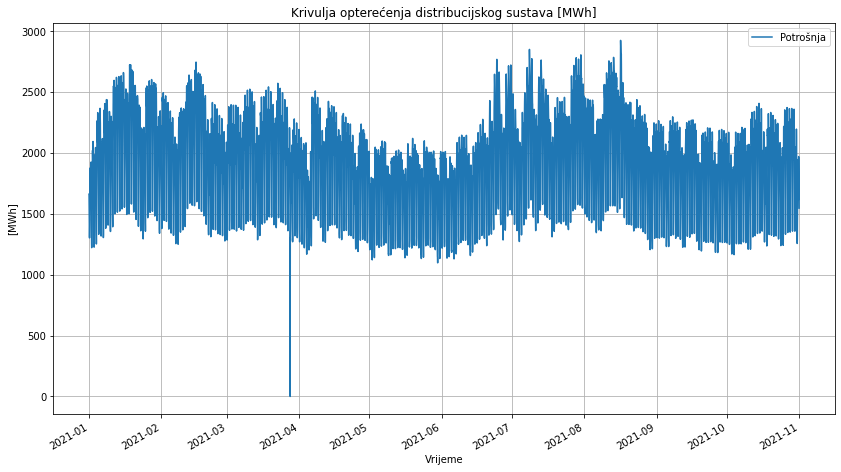

In [13]:
df.plot(use_index=True, title='Krivulja opterećenja distribucijskog sustava [MWh]', figsize=(14,8), grid=True, legend=True, ylabel='[MWh]', xlabel='Vrijeme')

Zanima me koja je srednja vrijednost za svaki sat u danu?

<AxesSubplot:xlabel='Sati', ylabel='MWh'>

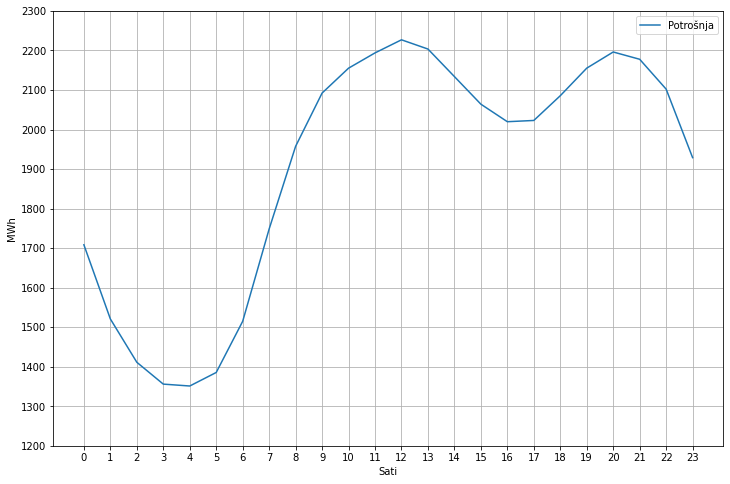

In [14]:
df.groupby(df.index.hour)['Potrošnja'].mean().plot(kind='line', xlabel='Sati', ylabel='MWh', legend=True, grid=True, figsize=(12,8), xticks = np.arange(0, 24, step=1), yticks=np.arange(1200, 2400, 100))

Ovdje sam koristio datetime kao index što omogućava jednostavno grupiranje po satima.

#### Napomena

Budući da je drukčija razina granularnosti (imamo potrošnju energije izraženu u satima i prosječnu dnevnu temperaturu), odlučio sam se na dnevnu agregaciju potrošnje. Razlog za to je da ćemo prilikom predviđanja na raspolaganju imati očekivanu prosječnu dnevnu temperaturu, a ne satnu. 

In [15]:
df = df.groupby(pd.Grouper(freq='D')).mean()

<AxesSubplot:xlabel='Datetime'>

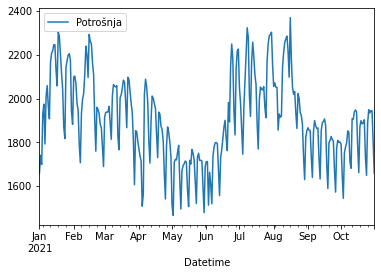

In [16]:
df.plot()

### Web scrapping

TO DO kako bi se trebalo, za sada sam manualno uzeo podatke prosječne dnevne temperature za 4 najveća HR grada (link: https://crd.meteoadriatic.net/statistics)

In [17]:
# Ucitaj podatke
df_temp_total = pd.read_excel('temperatura.xlsx', sheet_name=None)

In [18]:
# Concat all values in df_temp_total
df_temp = pd.concat(df_temp_total, ignore_index=True)

In [19]:
df_temp

,Vrijeme,Zagreb_temperatura,Split_temperatura,Osijek_temperatura,Rijeka_temperatura
0,2021-01-01 00,4.0,9.6,2.7,8.1
1,2021-01-02 00,5.6,11.3,5.5,9.8
2,2021-01-03 00,4.4,10.0,6.2,9.0
3,2021-01-04 00,3.3,9.5,3.5,7.5
4,2021-01-05 00,3.5,9.7,3.8,6.9
...,...,...,...,...,...
299,2021-10-27 00,7.6,18.1,6.1,12.3
300,2021-10-28 00,9.3,19.4,7.3,15.1
301,2021-10-29 00,9.4,19.2,9.2,17.0
302,2021-10-30 00,11.5,19.0,9.0,16.8


In [20]:
df_temp['Datetime'] = pd.to_datetime(df_temp['Vrijeme'])

In [21]:
df_temp = df_temp.set_index('Datetime')

In [22]:
df_temp = df_temp.drop(['Vrijeme'], axis=1)

In [23]:
df_temp['Prosjek'] = df_temp.mean(axis=1).round(2)

In [24]:
df_temp

,Zagreb_temperatura,Split_temperatura,Osijek_temperatura,Rijeka_temperatura,Prosjek
Datetime,,,,,
2021-01-01,4.0,9.6,2.7,8.1,6.10
2021-01-02,5.6,11.3,5.5,9.8,8.05
2021-01-03,4.4,10.0,6.2,9.0,7.40
2021-01-04,3.3,9.5,3.5,7.5,5.95
2021-01-05,3.5,9.7,3.8,6.9,5.98
...,...,...,...,...,...
2021-10-27,7.6,18.1,6.1,12.3,11.03
2021-10-28,9.3,19.4,7.3,15.1,12.78
2021-10-29,9.4,19.2,9.2,17.0,13.70


In [25]:
# Concat tables horizontally
df_concat = pd.concat([df, df_temp['Prosjek']], axis=1)
df_concat

,Potrošnja,Prosjek
Datetime,,
2021-01-01,1658.737021,6.10
2021-01-02,1740.763635,8.05
2021-01-03,1698.857552,7.40
2021-01-04,1929.874844,5.95
2021-01-05,1974.421844,5.98
...,...,...
2021-10-27,1934.383250,11.03
2021-10-28,1944.644156,12.78
2021-10-29,1943.962969,13.70


### Stacionarnost

#### Augmented Dickey-Fuller test

Provodim ADF test za stacionarnost. ADF test postavlja sljedeće hipoteze:
* Null hipoteza ($H_0$): Postoji [unit root](https://en.wikipedia.org/wiki/Unit_root) (a.k.a. vremenski nizovi nisu stacionarni)
* Alternativna hipoteza ($H_1$): Vremenski nizovi su stacionarni (ili trend-stacionarni)

Provodim ADF test:

In [26]:
from statsmodels.tsa.stattools import adfuller

print('ADF test za potrošnju:')
display(adfuller(df_concat['Potrošnja']))

print('ADF test za prosjek temperature:')
display(adfuller(df_concat['Prosjek']))

ADF test za potrošnju:


(-2.2811243046246497,
 0.1781280416658968,
 14,
 289,
 {'1%': -3.4531816058796143,
  '5%': -2.871593390724642,
  '10%': -2.5721268156511536},
 3247.611694909996)

ADF test za prosjek temperature:


(-1.606021020827442,
 0.48056827797402685,
 13,
 290,
 {'1%': -3.453102162983312,
  '5%': -2.871558538275452,
  '10%': -2.5721082282996433},
 1113.4520704232898)

Kao što vidimo, p value debelo je iznad 0.05, što znači da ne možemo odbaciti NULL hipotezu.

#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test

Provodim KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test koji postavlja suprotne hipoteze od ADF testa, tj.

* Null hipoteza ($H_0$): Vremenski nizovi su trend-stacionarni i ne postoji unit root
* Alternativna hipoteza ($H_1$): Vremenski nizovi su ne-stacionarni ili postoji unit root
    
Provodim KPSS test:

In [27]:
from statsmodels.tsa.stattools import kpss

print('KPSS test za potrošnju:')
display(kpss(df_concat['Potrošnja']))

print('KPSS test za prosjek temperature:')
display(kpss(df_concat['Prosjek']))

KPSS test za potrošnju:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.3221474207809318,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

KPSS test za prosjek temperature:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.8194911817847088,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Kao što vidimo, KPSS testom odbacujemo Null hipotezu i možemo zaključiti da su vremenski nizovi ne-stacionarni ili postoji unit root.

Budući da su i ADF i KPSS test potvrdili da vremenski nizovi nisu stacionarni, radimo diferencijaciju i provjeravamo prolaze li zatim vremenski nizovi ADF i KPSS testove.

In [28]:
df_concat = df_concat.dropna()

In [29]:
print('ADF test za potrošnju:')
display(adfuller(df_concat['Potrošnja']))

print('ADF test za prosjek temperature:')
display(adfuller(df_concat['Prosjek']))

print('KPSS test za potrošnju:')
display(kpss(df_concat['Potrošnja']))

print('KPSS test za prosjek temperature:')
display(kpss(df_concat['Prosjek']))

ADF test za potrošnju:


(-2.2811243046246497,
 0.1781280416658968,
 14,
 289,
 {'1%': -3.4531816058796143,
  '5%': -2.871593390724642,
  '10%': -2.5721268156511536},
 3247.611694909996)

ADF test za prosjek temperature:


(-1.606021020827442,
 0.48056827797402685,
 13,
 290,
 {'1%': -3.453102162983312,
  '5%': -2.871558538275452,
  '10%': -2.5721082282996433},
 1113.4520704232898)

KPSS test za potrošnju:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.3221474207809318,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

KPSS test za prosjek temperature:


/home/silvio/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.8194911817847088,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Kao što vidimo, nakon diferencijacije, i ADF i KPSS testovi pokazuju kako su vremenski nizovi stacionarni.

### Granger-Causality Test

Budući da je naš zadatak predviđanje potrošnje energije na temelju dane temperature, prvo provodimo 'Grangerov Test Kauzalnosti' kako bi vidjeli postoji li poveznica između vrijednosti temperature i potrošnje energije.

Grangerov test postavlja hipoteze:
* Null hipoteza ($H_0$): vremenski niz x (temperatura) nema utjecaja na vremenski niz y (potrošnja)
* Alternativna hipoteza ($H_1$): vremenski niz x (temperatura) ima utjecaja na vremenski niz y (potrošnja)

provodimo test:

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests

granger_result = grangercausalitytests(df_concat[['Potrošnja', 'Prosjek']], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1397  , p=0.7088  , df_denom=300, df_num=1
ssr based chi2 test:   chi2=0.1411  , p=0.7072  , df=1
likelihood ratio test: chi2=0.1411  , p=0.7072  , df=1
parameter F test:         F=0.1397  , p=0.7088  , df_denom=300, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0869  , p=0.9168  , df_denom=297, df_num=2
ssr based chi2 test:   chi2=0.1768  , p=0.9154  , df=2
likelihood ratio test: chi2=0.1767  , p=0.9154  , df=2
parameter F test:         F=0.0869  , p=0.9168  , df_denom=297, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6665  , p=0.5732  , df_denom=294, df_num=3
ssr based chi2 test:   chi2=2.0472  , p=0.5627  , df=3
likelihood ratio test: chi2=2.0402  , p=0.5641  , df=3
parameter F test:         F=0.6665  , p=0.5732  , df_denom=294, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8048  , p=0.5229  

Kao što se vidi iz rezultata, Grangerov test vraća p<0.05 za vrijednost prvih 10 lagova za različite testove. To zapravo znači da možemo odbaciti NULL hipotezu (da temperatura nema utjecaja na potrošnju energije), i zaključiti alternativnu hipotezu, tj. da temperatura ima utjecaja na potrošnju energije. 

Zanimljivo je da je vrijednost p<0.05 za prvih 12 lagova, što zapravo znači da postoji kauzalnost između dana mjerenja temperature i povezati temperaturu i sljedećih 12 dana potrošnje energije. Moguće da je razlog to što se temperatura ne mijenja iznenadno te tijekom dužeg perioda (godišnja doba) ima približno istu vrijednost.  

Za sanity-check, provodim i Grangerov test da vidim postoji li kauzalnost potrošnje energije na temperaturu:

In [31]:
granger_result = grangercausalitytests(df_concat[['Prosjek', 'Potrošnja']], maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0770  , p=0.7816  , df_denom=300, df_num=1
ssr based chi2 test:   chi2=0.0778  , p=0.7804  , df=1
likelihood ratio test: chi2=0.0778  , p=0.7804  , df=1
parameter F test:         F=0.0770  , p=0.7816  , df_denom=300, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1066  , p=0.8989  , df_denom=297, df_num=2
ssr based chi2 test:   chi2=0.2169  , p=0.8972  , df=2
likelihood ratio test: chi2=0.2168  , p=0.8973  , df=2
parameter F test:         F=0.1066  , p=0.8989  , df_denom=297, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2513  , p=0.8604  , df_denom=294, df_num=3
ssr based chi2 test:   chi2=0.7718  , p=0.8562  , df=3
likelihood ratio test: chi2=0.7708  , p=0.8564  , df=3
parameter F test:         F=0.2513  , p=0.8604  , df_denom=294, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1723  , p=0.9525  

Kao što vidimo, ne postoji utjecaj potrošnje na prosjek temperature.

### Treniram na temelju prvih 7.5 i testiram za zadnja 2.5 mjeseca

In [32]:
# Split data into train - test
train = df_concat[df_concat.index < '2021-09-01']
test = df_concat[df_concat.index > '2021-09-01']

# Set the values of test of Potrošnja to zero
test['Potrošnja'].values[:] = 0
test['Forecast'] = 0
#test.insert(column='Forecast', value=[0])

# Check shape
train.shape, test.shape

/tmp/ipykernel_56796/2202701338.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = 0


((243, 2), (60, 3))

### Using SARIMA for forecasting

Dekompozicija potrošnje da se vidi sezonalnost i trend

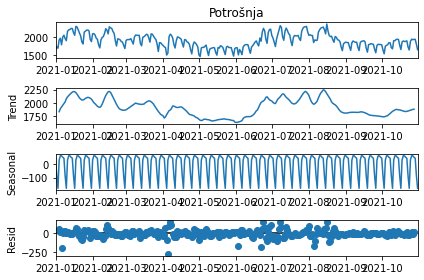

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series
decompose_data = seasonal_decompose(df_concat.Potrošnja, model="additive")
decompose_data.plot();

In [34]:
# Izracunaj najbolji order
from pmdarima.arima import auto_arima

auto_arima_result = auto_arima(y=df_concat['Potrošnja'], x=df_concat, trace=True, seasonal=True, information_criterion='aic')

auto_arima_result.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3762.347, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3763.973, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3763.362, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3760.347, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3739.221, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3714.543, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3734.262, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3715.248, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3710.437, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3710.614, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3712.161, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3711.783, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1850.221
Date:                Sat, 11 Jun 2022   AIC                           3708.442
Time:                        23:33:14   BIC                           3723.297
Sample:                             0   HQIC                          3714.385
                                - 304                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2813      0.099      2.830      0.005       0.086       0.476
ma.L1         -0.3322      0.095     -3.503      0.000      -0.518      -0.146
ma.L2         -0.4428      0.061     -7.300      0.000      -0.562      -0.324
sigma2      1.175e+04    970.825     12.107      0.000    9850.844    1.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.51
Prob(Q):                              0.99   Prob(JB):                         0.06
Heteroskedasticity (H):               0.70   Skew:                             0.33
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(endog=df_concat['Potrošnja'], exog=df_concat['Prosjek'] , order=(1, 1, 2) ,seasonal_order=(0,1,0,7), freq='D')

results=model.fit()

/home/silvio/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:xlabel='Datetime'>

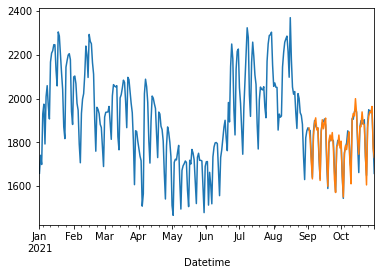

In [57]:
test.loc[:, ('Potrošnja')] = results.predict(exog=test.loc[:, ('Prosjek')])
df_concat['Potrošnja'].plot()
test['Potrošnja'].plot()

Zaključak je da model možemo koristiti za predikcije

### Forecast zadnja dva mjeseca 2021. godine

In [58]:
# Generaze datetime
datetime = pd.date_range(start='2021-11-01', end='2021-12-31')

# Get prosjek
df_temp_prosjek = pd.read_excel('temperatura_predviđanje.xlsx', sheet_name='podaci_testiranje')

# Set the index
df_temp_prosjek['Datetime'] = pd.to_datetime(df_temp_prosjek['Vrijeme'])
df_temp_prosjek = df_temp_prosjek.set_index('Datetime')
df_temp_prosjek = df_temp_prosjek.drop(['Vrijeme'], axis=1)

# Generate prosjek
df_temp_prosjek['Prosjek'] = df_temp_prosjek.mean(axis=1).round(2)

# Create new dataframe
df_forecast = pd.DataFrame(df_temp_prosjek, index=datetime, columns=['Potrošnja', 'Prosjek', 'Forecast'])
df_forecast.index.name = 'Datetime'
df_forecast['Potrošnja'] = 0
df_forecast['Forecast'] = 0

In [59]:
df_forecast['Forecast'] = results.predict(end='2021-12-31', start='2021-11-01', exog=df_forecast['Prosjek'])

<AxesSubplot:xlabel='Datetime'>

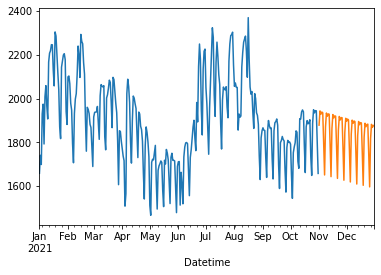

In [60]:
df_concat.Potrošnja.plot()
df_forecast.Forecast.plot()